# ECE143 Board Game Geek Data Analysis Group 1 Winter 2022

## Data Clean Up

In [33]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np # linear algebra
from scipy.optimize import curve_fit
from scipy.stats import norm
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
from modular_code.mod_code import manipulate_Y_vs_X_data, plot_top_10_hbar, create_Min_Max_df
import warnings
warnings.filterwarnings("ignore")

In [7]:
# user_ratings=pd.read_csv('../original_data/user_ratings.csv')
sub_ctg=pd.read_csv('../original_data//subcategories.csv')
publisher=pd.read_csv('../original_data//publishers_reduced.csv')
game_df=pd.read_csv('../original_data/games.csv')
themes = pd.read_csv('../original_data//themes.csv')
ratings = pd.read_csv('../original_data//ratings_distribution.csv')
mechanics = pd.read_csv('../original_data//mechanics.csv')

Removed unwanted columns

In [8]:
game_df = game_df.drop(['BestPlayers', 'GoodPlayers','Family','ImagePath', 'LanguageEase'], axis=1)
game_df

BGGId                                      Name  \
0           1                                Die Macher   
1           2                              Dragonmaster   
2           3                                   Samurai   
3           4                            Tal der Könige   
4           5                                   Acquire   
...       ...                                       ...   
21920  347146                                   Salvage   
21921  347521  Blitzkrieg!: World War Two in 20 Minutes   
21922  348955       Rock Paper Scissors: Deluxe Edition   
21923  349131                                  Splitter   
21924  349161                             Captains' War   

                                             Description  YearPublished  \
0      die macher game seven sequential political rac...           1986   
1      dragonmaster tricktaking card game base old ga...           1981   
2      samurai set medieval japan player compete gain...           1998   
3      triangular box luxurious large block tal der k...           1992   
4      acquire player strategically invest business t...           1964   
...                                                  ...            ...   
21920  oil tanker fire rescue team send deal   damage...           2021   
21921  new square edition include nippon expansion up...           2019   
21922  million year people force play timehonored gam...           2021   
21923  splitter group number score point mdash s s md...           2021   
21924  gather resource build crew fight rival claim p...              0   

       GameWeight  AvgRating  BayesAvgRating    StdDev  MinPlayers  \
0          4.3206    7.61428         7.10363  1.579790           3   
1          1.9630    6.64537         5.78447  1.454400           3   
2          2.4859    7.45601         7.23994  1.182270           2   
3          2.6667    6.60006         5.67954  1.231290           2   
4          2.5031    7.33861         7.14189  1.335830           2   
...           ...        ...             ...       ...         ...   
21920      0.0000    7.45000         5.52462  1.554930           3   
21921      1.6667    7.92276         5.56323  0.894204           1   
21922      4.5625    6.96970         5.53964  4.052570           1   
21923      1.0000    6.48235         5.52631  1.160070           1   
21924      2.5000    9.91429         5.50806  0.368117           1   

       MaxPlayers  ...  Rank:partygames  Rank:childrensgames  Cat:Thematic  \
0               5  ...            21926                21926             0   
1               4  ...            21926                21926             0   
2               4  ...            21926                21926             0   
3               4  ...            21926                21926             0   
4               6  ...            21926                21926             0   
...           ...  ...              ...                  ...           ...   
21920           4  ...            21926                21926             0   
21921           2  ...            21926                21926             0   
21922           3  ...            21926                21926             0   
21923          12  ...            21926                21926             0   
21924           6  ...            21926                21926             0   

       Cat:Strategy  Cat:War  Cat:Family  Cat:CGS  Cat:Abstract  Cat:Party  \
0                 1        0           0        0             0          0   
1                 1        0           0        0             0          0   
2                 1        0           0        0             0          0   
3                 0        0           0        0             0          0   
4                 1        0           0        0             0          0   
...             ...      ...         ...      ...           ...        ...   
21920             0        0           0        0             0          0

### Filling NaNs

ComAgeRec is found to be missing in many rows. We use general conventions to fill missing values

In [9]:
children_idx = game_df[game_df['Cat:Childrens'] == 1].index
game_df.loc[children_idx, ['ComAgeRec']].fillna(7, inplace = True)
family_idx = game_df[game_df['Cat:Family'] == 1].index
game_df.loc[family_idx, ['ComAgeRec']].fillna(12, inplace = True)
game_df.ComAgeRec = game_df.ComAgeRec.fillna(18)

After this fill, we look for other NaN values

In [10]:
game_df[game_df.isnull().values]

BGGId                         Name Description  YearPublished  \
14243  170984  Timeline: Sports et Loisirs         NaN           2014   

       GameWeight  AvgRating  BayesAvgRating   StdDev  MinPlayers  MaxPlayers  \
14243         1.0    6.64387         5.53658  1.62527           2           8   

       ...  Rank:partygames  Rank:childrensgames  Cat:Thematic  Cat:Strategy  \
14243  ...            21926                21926             0             0   

       Cat:War  Cat:Family  Cat:CGS  Cat:Abstract  Cat:Party  Cat:Childrens  
14243        0           0        0             0          0              0  

[1 rows x 43 columns]

Fill this value with placeholder string

In [11]:
idx = game_df[game_df.isnull().values].index
game_df.Description.loc[idx] = "No Description Found"

c:\users\manas\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [13]:
game_df.to_csv('../data/games_cleaned.csv')

## Data Visualization 
After downloading and cleaning the dataset, we move towards exploring it. Through different visualizations, we try to understand if our hypotheses make sense with respect to the data

In [21]:
# Set figsize for plots
plt.rcParams["figure.figsize"] = (10,6)

In [30]:
# Loading the files required
games_df = pd.read_csv("../data/games_cleaned.csv").drop(['Unnamed: 0'], axis=1).set_index('BGGId')
backup_games_df = games_df.copy() # Backup games_df
themes_df = pd.read_csv("../data/themes.csv").set_index('BGGId')
backup_themes_df = themes_df.copy() # Backup themes_df
mechanics_df = pd.read_csv("../data/mechanics.csv").set_index('BGGId')
backup_mechanics_df = mechanics_df.copy() # Backup mechanics_df
subcategories_df = pd.read_csv("../data/subcategories.csv")
publisher_df = pd.read_csv("../data/publishers_reduced.csv")

In [3]:
# Basic description of data
games_df.head(10)

Name                                        Description  \
BGGId                                                                          
1              Die Macher  die macher game seven sequential political rac...   
2            Dragonmaster  dragonmaster tricktaking card game base old ga...   
3                 Samurai  samurai set medieval japan player compete gain...   
4          Tal der Könige  triangular box luxurious large block tal der k...   
5                 Acquire  acquire player strategically invest business t...   
6      Mare Mediterraneum  ancient land mediterranean player attempt sati...   
7               Cathedral  cathedral player set piece different color pie...   
8       Lords of Creation  interesting offering warfrog player god seek d...   
9            El Caballero  refer sequel el grande el caballero share aspe...   
10              Elfenland  elfenland redesign original white wind game el...   

       YearPublished  GameWeight  AvgRating  BayesAvgRating   StdDev  \
BGGId                                                                  
1               1986      4.3206    7.61428         7.10363  1.57979   
2               1981      1.9630    6.64537         5.78447  1.45440   
3               1998      2.4859    7.45601         7.23994  1.18227   
4               1992      2.6667    6.60006         5.67954  1.23129   
5               1964      2.5031    7.33861         7.14189  1.33583   
6               1989      3.0000    6.55370         5.54614  1.65350   
7               1978      1.7950    6.52083         6.13713  1.32963   
8               1993      2.4000    6.10716         5.56602  1.32872   
9               1998      3.1824    6.45265         5.92290  1.43335   
10              1998      2.1578    6.69695         6.47733  1.25365   

       MinPlayers  MaxPlayers  ComAgeRec  ...  Rank:partygames  \
BGGId                                     ...                    
1               3           5  14.366667  ...            21926   
2               3           4  18.000000  ...            21926   
3               2           4   9.307692  ...            21926   
4               2           4  13.000000  ...            21926   
5               2           6  11.410256  ...            21926   
6               2           6  13.000000  ...            21926   
7               2           2   8.142857  ...            21926   
8               2           5  18.000000  ...            21926   
9               2           4  11.777778  ...            21926   
10              2           6   8.194444  ...            21926   

       Rank:childrensgames  Cat:Thematic  Cat:Strategy  Cat:War  Cat:Family  \
BGGId                                                                         
1                    21926             0             1        0           0   
2                    21926             0             1        0           0   
3                    21926             0             1        0           0   
4                    21926             0             0        0           0   
5                    21926             0             1        0           0   
6                    21926             0             0        0           0   
7                    21926             0             0        0           0   
8                    21926             0             0        0           0   
9                    21926             0             1        0           0   
10                   21926             0             0        0           1   

       Cat:CGS  Cat:Abstract  Cat:Party  Cat:Childrens  
BGGId                                                   
1            0             0          0              0  
2            0             0          0              0  
3            0             0          0              0  
4            0             0          0              0  
5            0             0          0              0  
6            0             0          0              0

### Data Point 0: Correlation Between the Board Game Design Features and User Ratings
As a board game developer, it is crucial to analyze which board game design features are correlated with the user ratings. With the correlation heatmap, board game developers can optimize the board game design features to improve the product ratings and players' satisfaction in the future.

[Text(0.5, 0, 'Game\nComplexity'),
 Text(1.5, 0, 'Average\nUser Rating'),
 Text(2.5, 0, 'Bayes Average\nUser Rating'),
 Text(3.5, 0, 'Minimum Number\nof Players'),
 Text(4.5, 0, 'Maximum Number\nof Players'),
 Text(5.5, 0, 'Estimated\nPlaytime'),
 Text(6.5, 0, "Players' Minimum\nPlaytime"),
 Text(7.5, 0, "Players' Maximum\nPlaytime"),
 Text(8.5, 0, 'Recommended\nAge'),
 Text(9.5, 0, 'Number of\nUser Ratings'),
 Text(10.5, 0, 'Number of People\nWho Wish to Have')]

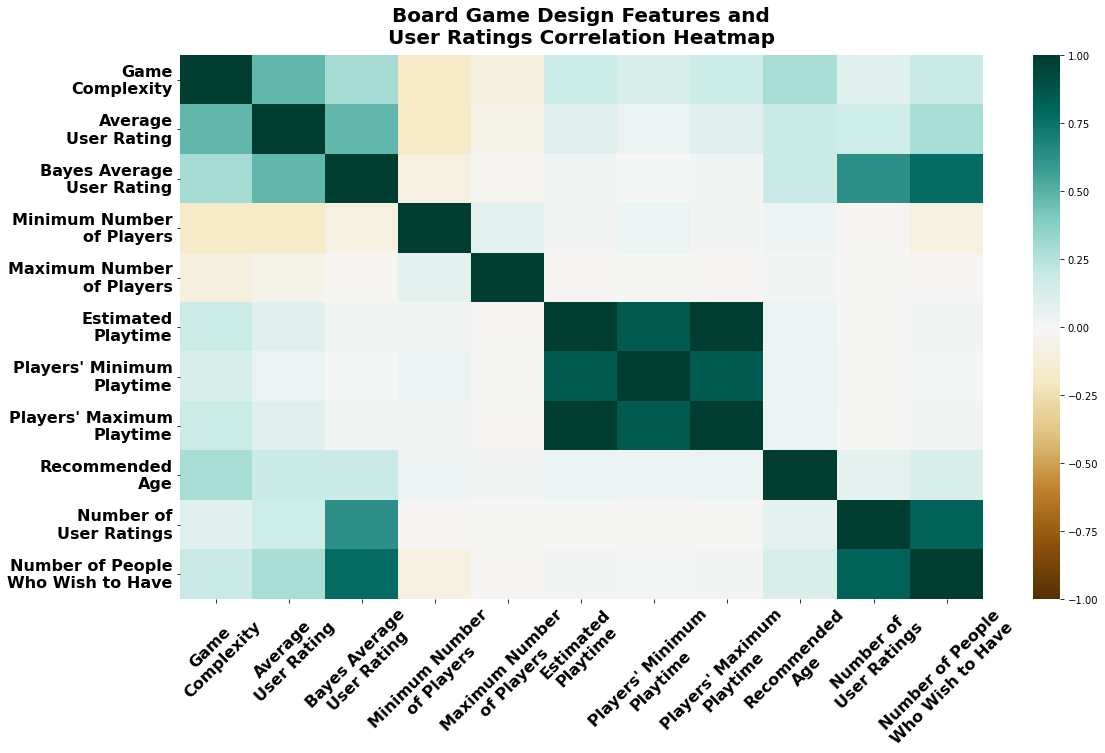

In [5]:
# Board Game Design Features Dataframe
design_features_df = games_df.loc[:, ['GameWeight', 'AvgRating', 'BayesAvgRating', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime', 'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumWish']].copy()
# Rename the features
design_features_df.rename(columns={'GameWeight': 'Game\nComplexity', 'AvgRating': 'Average\nUser Rating', 'BayesAvgRating': 'Bayes Average\nUser Rating',
                                    'MinPlayers': 'Minimum Number\nof Players', 'MaxPlayers': 'Maximum Number\nof Players',
                                    'MfgPlaytime': 'Estimated\nPlaytime', 'ComMinPlaytime': 'Players\' Minimum\nPlaytime', 'ComMaxPlaytime': 'Players\' Maximum\nPlaytime',
                                    'MfgAgeRec': 'Recommended\nAge', 'NumUserRatings': 'Number of\nUser Ratings', 'NumWish': 'Number of People\nWho Wish to Have'}, inplace=True)
#mask = np.triu(np.ones_like(design_features_df.corr(), dtype=np.bool))
plt.figure(figsize=(18, 10))
heatmap = sns.heatmap(design_features_df.corr(), mask = None, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Board Game Design Features and\nUser Ratings Correlation Heatmap', fontdict={'fontsize':20, 'fontweight':'bold'}, pad=12)
heatmap.set_yticklabels(design_features_df.columns, fontsize = 16, fontweight='bold')
heatmap.set_xticklabels(design_features_df.columns, fontsize = 16, fontweight='bold', rotation=45)

### Data Point 1: Games Published per Year

We are interested in the trend of in supposed trend of increased demand in board games. To find this trend we filter data to after 1950 since Board Game Geek has data going into the B.C.s

In [6]:
# Sum games per year
games_per_year = pd.DataFrame(games_df['YearPublished'].value_counts()) # data from of yearpublish vs count
games_per_year = games_per_year.reset_index() # adds index
games_per_year = games_per_year.rename(columns={"index": "Year", "YearPublished": "Count"}) # renames columns
games_per_year = games_per_year.sort_values(by=['Year']) # sort by year

In [7]:
# filter after 1950
after_year_mask = games_per_year["Year"] >= 1950
gpy_after_year = games_per_year[after_year_mask]

In [8]:
# Plot bar graph of game per year after 1950
fig = px.bar(gpy_after_year, x="Year", y="Count",
                 labels={
                     "Year": "Year of Publication",
                     "Count": "Number of Games Published",
                 },
                title="Published Games per Year")

fig.show()

### Data Point 2: Game Weight
Board game Geek has a rating system of for game complexity. This system ranks games as from 1 to 5. This is a possible key indicator to whether a board is well recieve and/or sells well. First we sum the amount of games in each range to determine if there is an opening in the market. Then we compared complexity to attributes that tied to increased ownership. these include user rating, ownership and number of people who want the game.

In [9]:
#remove zeros (BGG has rating 1-5)
df_no_zeros_mask = games_df["GameWeight"] >= 1
df_without_zeros = games_df[df_no_zeros_mask]

In [10]:
# histogram of game complexity 
fig = px.histogram(df_without_zeros, x="GameWeight",
                 labels={
                     "GameWeight": "BGG Game Weight",
                 },
                title="Number of Games at Each Weight").update_layout(yaxis_title="Number of Games")

fig.show()

In [12]:
# Scatter plot of complexity vs Average User Rating
fig = px.scatter(df_without_zeros, x="AvgRating", y="GameWeight", trendline="ols",opacity=0.5,

                 labels={
                    "AvgRating": "Average User Rating",
                    "GameWeight": "BGG Game Weight",
                 },
                title="Game Weight vs Average User Rating Trendline")
fig.update_layout(yaxis_range=[1,5])
fig.data[1].update(line_color='red') 
fig.show()

In [13]:
# Filter complexity data to last 30 years
after_year_mask = df_without_zeros["YearPublished"] >= 1992
games_after_year = df_without_zeros[after_year_mask]
games_after_year = games_after_year.sort_values(by=['YearPublished'])

In [19]:
# Scatter plot of complexity vs Average User Rating, size is number owned, color is number wanted
fig = px.scatter(games_after_year, x="AvgRating", y="GameWeight",trendline="ols", animation_frame="YearPublished", animation_group="AvgRating", size="NumOwned", color="NumWant", hover_name="Name",
                labels={
                    "AvgRating": "Average User Rating",
                    "GameWeight": "BGG Game Weight",
                 },
                title="Game Weight vs Average User Rating (Size: Number Owned, Color: Number Wanted)")
fig.show()

Based on majority of games being in the lower half of  complexity, and trends show that a more complex game will have higher rating and ownership suggest that designers should target high complexity games. 

### Data point 3: Minimum and Maximum Numbers of Players
The optimal minimum and maximum numbers of players for a board game are two of the most important board game design features. Some categories of the board game are more suitable for team players, and some others might be more exciting to play individually. The dataset will be visualized with boxplots to determine the minimum, first quartile, median, third quartile, and maximum players for each board game's minimum and maximum numbers of players per category.

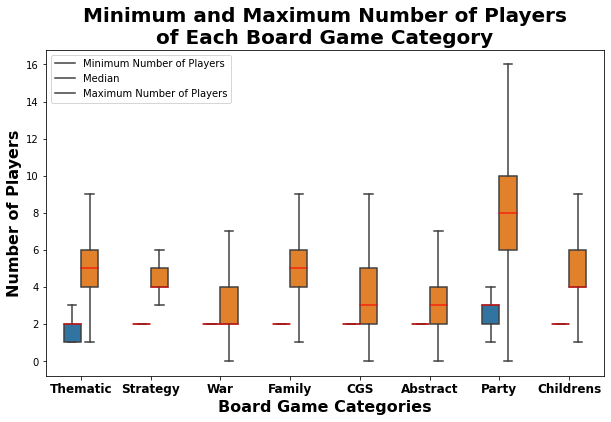

In [22]:
# Create a dataframe that consists of Board Game Category Name, Minimum Number of Players, and Maximum Number of Players for each Board Game Category
min_max_thematic_df = create_Min_Max_df(games_df, "Cat:Thematic", "Thematic")
games_df = backup_games_df.copy()
min_max_strategy_df = create_Min_Max_df(games_df, "Cat:Strategy", "Strategy")
games_df = backup_games_df.copy()
min_max_war_df = create_Min_Max_df(games_df, "Cat:War", "War")
games_df = backup_games_df.copy()
min_max_family_df = create_Min_Max_df(games_df, "Cat:Family", "Family")
games_df = backup_games_df.copy()
min_max_cgs_df = create_Min_Max_df(games_df, "Cat:CGS", "CGS")
games_df = backup_games_df.copy()
min_max_abstract_df = create_Min_Max_df(games_df, "Cat:Abstract", "Abstract")
games_df = backup_games_df.copy()
min_max_party_df = create_Min_Max_df(games_df, "Cat:Party", "Party")
games_df = backup_games_df.copy()
min_max_childrens_df = create_Min_Max_df(games_df, "Cat:Childrens", "Childrens")
games_df = backup_games_df.copy()

# Concatenate the dataframe
cdf = pd.concat([min_max_thematic_df, min_max_strategy_df, min_max_war_df, min_max_family_df, min_max_cgs_df, min_max_abstract_df, min_max_party_df, min_max_childrens_df])
# Melt the dataframe
mdf = pd.melt(cdf, id_vars=['Cat'], var_name=['Minimum_or_Maximum_Number_of_Players']) 

# Plot the Boxplot
ax = sns.boxplot(x="Cat", y="value", hue="Minimum_or_Maximum_Number_of_Players", data=mdf, showfliers=False, width = 0.5, 
                    palette="tab10", medianprops=dict(color="red", alpha=0.7))  # RUN PLOT   
ax.set_ylabel("Number of Players", fontsize=16, fontweight='bold')
ax.set_xlabel("Board Game Categories", fontsize=16, fontweight='bold')
ax.set_xticklabels(['Thematic', 'Strategy', 'War', 'Family', 'CGS', 'Abstract', 'Party', 'Childrens'], fontweight='bold', fontsize=12)
ax.legend(['Minimum Number of Players', '_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','Median','Maximum Number of Players'])
plt.title("Minimum and Maximum Number of Players\nof Each Board Game Category", fontweight='bold', fontsize=20)
plt.show()

The boxplots below presents how the minimum and maximum number of players of a board games change the average user ratings. 

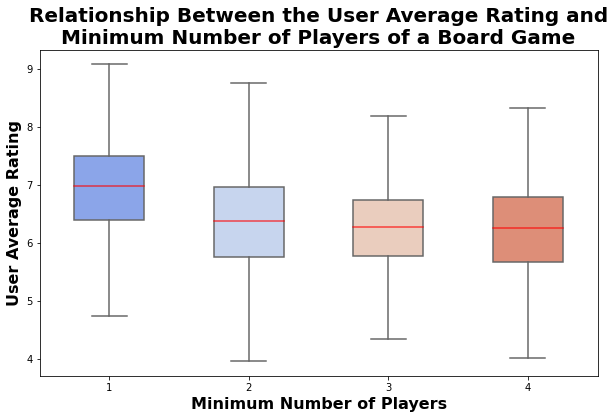

In [25]:
# Filter out the Minimum Number of Players with less than 5 value
df_no_zeros_mask = games_df["MinPlayers"].between(0, 5, inclusive=False)
df_without_zeros = games_df[df_no_zeros_mask]

# Plot the relationship between the average user rating and minimum number of players
ax = sns.boxplot(x="MinPlayers", y="AvgRating", data=df_without_zeros, showfliers=False, width = 0.5, 
                    palette="coolwarm", medianprops=dict(color="red", alpha=0.7))  # RUN PLOT
ax.set_ylabel("User Average Rating", fontsize=16, fontweight='bold')
ax.set_xlabel("Minimum Number of Players", fontsize=16, fontweight='bold')
plt.title("Relationship Between the User Average Rating and\nMinimum Number of Players of a Board Game", fontweight='bold', fontsize=20)
plt.show()

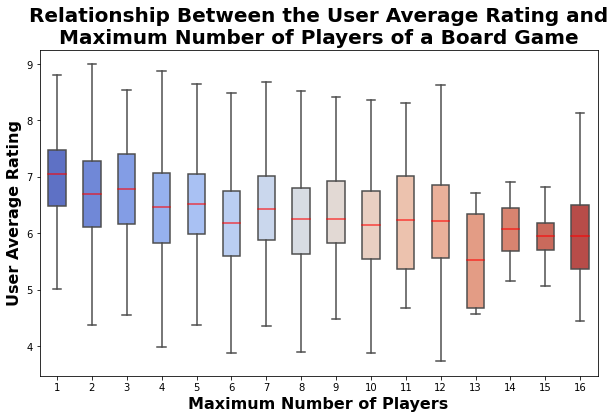

In [24]:
# Filter out the Maximum Number of Players with 0 value and more than 16
df_no_zeros_mask = games_df["MaxPlayers"].between(0, 17, inclusive=False)
df_without_zeros = games_df[df_no_zeros_mask]

# Plot the relationship between the average user rating and minimum number of players
#plt.figure(figsize=(10, 10))
ax = sns.boxplot(x="MaxPlayers", y="AvgRating", data=df_without_zeros, showfliers=False, width = 0.5, 
                    palette="coolwarm", medianprops=dict(color="red", alpha=0.7))  # RUN PLOT
ax.set_ylabel("User Average Rating", fontsize=16, fontweight='bold')
ax.set_xlabel("Maximum Number of Players", fontsize=16, fontweight='bold')
plt.title("Relationship Between the User Average Rating and\nMaximum Number of Players of a Board Game", fontweight='bold', fontsize=20)
plt.show()

### Data Point 4: Understanding the recommended ages
We are mainly interested in understanding the effect of recommended ages with popularity. The columns 'ComAgeRec' and 'MfgAgeRec' show the community and manufacturer recommendations.

#### Manufacturer and Community Ages

We study the ages and the number of games designed for each range of ages. Since community ages are means and thus non integral, for the sake of this analysis we convert them to the lower integer

In [26]:
games_df['ComAgeRec2'] = games_df['ComAgeRec'].astype('int')

popularity_metrics = ['NumWant','NumWish','NumWeightVotes']

Text(0.5, 1.0, 'Distribution histogram and modeling of game popularity w.r.t. Recommended Manufacturer Age')

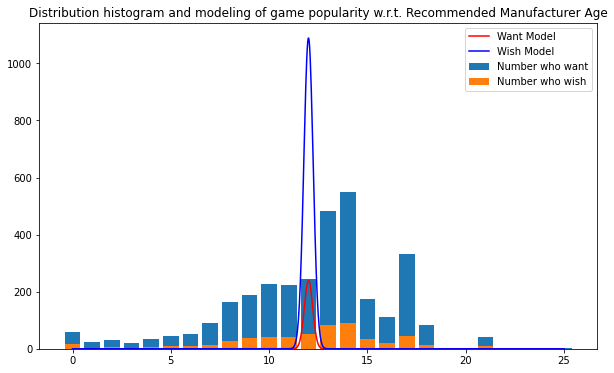

In [32]:
# Bar plot of mean of Average Rating, Bayes Rating by Manufacturer age
df = games_df.groupby('MfgAgeRec').mean()

# Community vs User Rating
df = games_df.groupby('MfgAgeRec').mean()


def f(x, mu, sigma):
    return np.exp(-1*(x-mu)*(x-mu)/2/sigma/sigma)/np.sqrt(2*np.pi*sigma*sigma)


popt_wish, pvar_wish = curve_fit(f, games_df.MfgAgeRec.values, games_df.NumWish.values)
popt_want, pvar_want = curve_fit(f, games_df.MfgAgeRec.values, games_df.NumWant.values, maxfev=5000)

popt_wish, pvar = norm.fit(df[popularity_metrics[0]]) 

popt_wish = np.abs(popt_wish)
popt_want = np.abs(popt_want)

xmin, xmax = df.index.min(), df.index.max()
x = np.linspace(xmin, xmax, 1000)

plt.bar(df.index, df[popularity_metrics[1]], label='Number who want')
plt.bar(df.index, df[popularity_metrics[0]], label='Number who wish')
plt.plot(x,f(x,popt_want[0],popt_want[1]*df[popularity_metrics[0]].mean())/popt_want[1], 
         color='red',label='Want Model')
plt.plot(x,f(x,popt_wish[0],popt_wish[1]*df[popularity_metrics[1]].mean())/popt_wish[1], 
         color='blue',label='Wish Model')
plt.legend()
plt.title("Distribution histogram and modeling of game popularity w.r.t. Recommended Manufacturer Age")



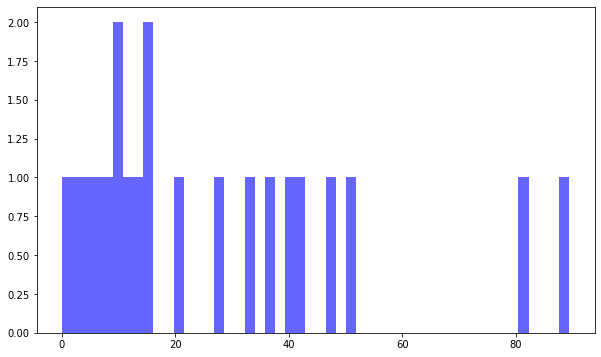

In [41]:
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(df[popularity_metrics[0]]) 
  
# Plot the histogram.
plt.hist(df[popularity_metrics[0]], bins=50, density=False, alpha=0.6, color='b')
  
# Plot the PDF.
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 100)
#p = norm.pdf(x, mu, std)
  
#plt.plot(x, p, 'k', linewidth=2)
#title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
#plt.title(title)
  
plt.show()

Text(0.5, 1.0, 'Distribution modeling of game popularity w.r.t. Community Recommended Age')

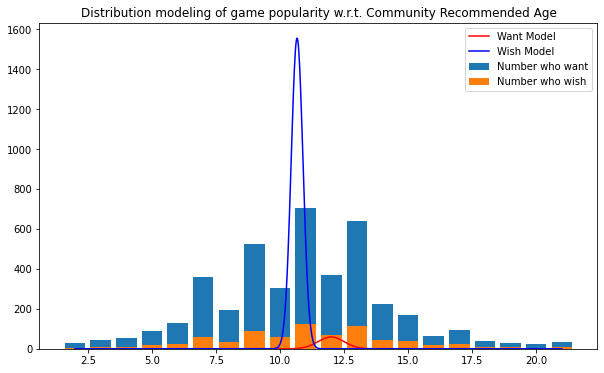

In [35]:
# Bar plot of mean of Average Rating, Bayes Rating by Community age
df = games_df.groupby('ComAgeRec2').mean()
# # df[popularity_metrics].plot.bar(xlabel='Age',
# #     ylabel='Rating',title='Com Age vs Rating')

def f(x, mu, sigma):
    return np.exp(-1*(x-mu)*(x-mu)/2/sigma/sigma)/np.sqrt(2*np.pi*sigma*sigma)

#df.index.values, df[popularity_metrics[0]].values)
popt_wish, pvar = curve_fit(f, game_df.ComAgeRec.values, game_df.NumWish.values)
popt_want, pvar = curve_fit(f, game_df.ComAgeRec.values, game_df.NumWant.values)

popt_wish = np.abs(popt_wish)
popt_want = np.abs(popt_want)

xmin, xmax = df.index.min(), df.index.max()
x = np.linspace(xmin, xmax, 1000)

plt.bar(df.index, df[popularity_metrics[1]], label='Number who want')
plt.bar(df.index, df[popularity_metrics[0]], label='Number who wish')
plt.plot(x,f(x,popt_want[0],popt_want[1]*df[popularity_metrics[0]].mean())/popt_want[1], 
         color='red',label='Want Model')
plt.plot(x,f(x,popt_wish[0],popt_wish[1]*df[popularity_metrics[1]].mean())/popt_wish[1], 
         color='blue',label='Wish Model')
plt.legend()
plt.title("Distribution modeling of game popularity w.r.t. Community Recommended Age")

#### Difference in Community and Manufacturer's recommendations
On finding the difference between the recommended ages, we can get an understanding of how far from the intended community did the game end up being used.

In [ ]:
games_df['ComMfgChange'] = games_df['ComAgeRec'] - games_df['MfgAgeRec']
games_df.ComMfgChange.describe()

While not advisable (safety issues), the community age being lower than the recommended age means that the game is easy to operate and of interest to a wider range of the population. There are 7500+ such games.

In [ ]:
idx = games_df.ComMfgChange[games_df.ComMfgChange < 0].index
games_df.loc[idx, ['Cat:Thematic', 'Cat:Strategy', 'Cat:War',
       'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']].sum().plot.bar(
    title='Category wise games with wider community reach than expected',
    xlabel='Category',
    ylabel='Number of games')

### Data Point 5: Popularity of Different Board Game Categories

Analyzing and studying the popularity of different board game categories is crucial for board game developers publishers, and manufacturers. With the data visualization, the board game industry would be able to know which board game categories they should put more effort in the game development to maximize their profits. Besides that, the board game industry can continue to get more feedback from the users to improve the overall board game designs that have low popularity.

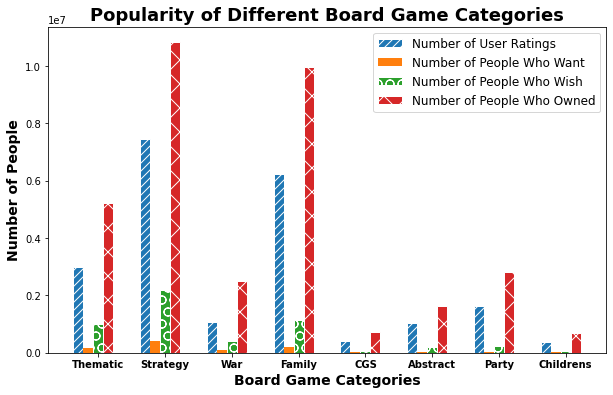

In [42]:
# Get the popularity data including NumUserRatings, NumWant, NumWish, NumOwned, NumComments
# NumUserRatings - Number of People Rated the Board Game
# NumWant        - Number of People Wanted the Board Game
# NumWish        - Number of People Wish to have the Board Game
# NumOwned       - Number of People Owned the Board Game
popularity_data = games_df[['NumUserRatings', 'NumWant', 'NumWish', 'NumOwned']].to_numpy()
# Get BGGidx 
BGGid = games_df.index[:].tolist()
# Convert the popularity array to dataframe
popularity_data_df = pd.DataFrame(popularity_data, index = BGGid, columns = ['NumUserRatings', 'NumWant', 'NumWish', 'NumOwned'])

# Board Game Categories
board_game_categories = ['Thematic', 'Strategy', 'War', 'Family', 'CGS', 'Abstract', 'Party', 'Childrens']

# Initialize an array that stores counts of Row = Popularity Features, Column = Board Game Categories
board_game_Pop_vs_Catg = np.zeros((popularity_data.shape[1], len(board_game_categories)))

# Get the popularity counts based on board game category
board_game_Pop_vs_Catg = manipulate_Y_vs_X_data(games_df, board_game_Pop_vs_Catg, popularity_data_df)

# Plot multiple bar graphs
X_axis = np.arange(len(board_game_categories))
  
plt.bar(X_axis - 0.3, board_game_Pop_vs_Catg[0, :].tolist(), 0.15, label = 'Number of User Ratings', hatch = "///", edgecolor = 'white')
plt.bar(X_axis - 0.15, board_game_Pop_vs_Catg[1, :].tolist(), 0.15, label = 'Number of People Who Want')
plt.bar(X_axis, board_game_Pop_vs_Catg[2, :].tolist(), 0.15, label = 'Number of People Who Wish', hatch = "O", edgecolor = 'white')
plt.bar(X_axis + 0.15, board_game_Pop_vs_Catg[3, :].tolist(), 0.15, label = 'Number of People Who Owned', hatch = "x", edgecolor = 'white')
  
plt.xticks(X_axis, board_game_categories, fontsize=10, fontweight = 'bold')
plt.xlabel("Board Game Categories", fontsize = 14, fontweight = 'bold')
plt.ylabel("Number of People", fontsize = 14, fontweight = 'bold')
plt.title("Popularity of Different Board Game Categories", fontsize=18, fontweight = 'bold')
plt.legend(prop={'size': 12})
plt.show()

### Data Point 6: Reimplementation

We study the effect of number of reimlementations of a game depending on the number of people who own the game, due to the large amount of people we use a log10 scale for the number of people owning the board games.

Text(0.5, 0, 'Number of Expansions')

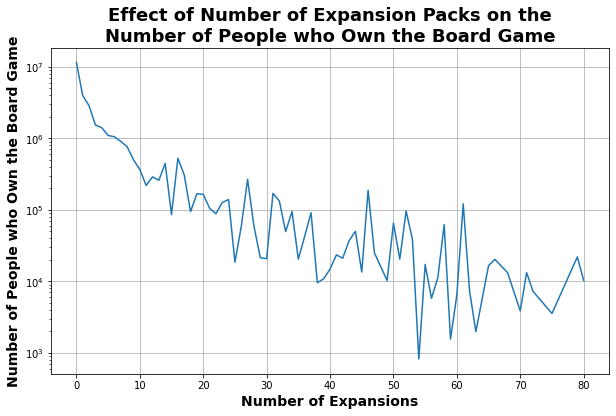

In [117]:
# NumOwned_log - log10 of Number of People Owned the Board Game
# NumWant_log  - log 10 of Number of People Wanted the Board Game
# NumWish_log  - log10 of Number of People Wish to have the Board Game
games_df['NumOwned_log'] = np.log10(games_df['NumOwned'], where=games_df['NumOwned'] > 0)
games_df['NumWant_log'] = np.log10(games_df['NumWant'], where=games_df['NumWant'] > 0)
games_df['NumWish_log'] = np.log10(games_df['NumWish'], where=games_df['NumWish'] > 0)

# NumExpansions - Number of Expansion packs of the board game
# NumAlternates - Number of alternate versions of the board game 
# NumImplementations - Number of reimplementations of the board game 
df = games_df[['NumExpansions','NumAlternates','NumOwned','NumImplementations']]
# drop values >80 to limit outliers with large number of expansion packs
df = df.drop(df.index[df['NumExpansions'] >80])
# drop values >40 to limit outliers with large number of alternate versions
df = df.drop(df.index[df['NumAlternates'] >40])
df2 = df.groupby('NumExpansions')['NumOwned'].sum()
ax = df2.plot()
ax.grid(True)
ax.set_yscale('log')
plt.title("Effect of Number of Expansion Packs on the\nNumber of People who Own the Board Game", fontsize=18, fontweight = 'bold')
ax.set_ylabel("Number of People who Own the Board Game", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Number of Expansions", fontsize = 14, fontweight = 'bold')

Text(0.5, 0, 'Number of Implementations')

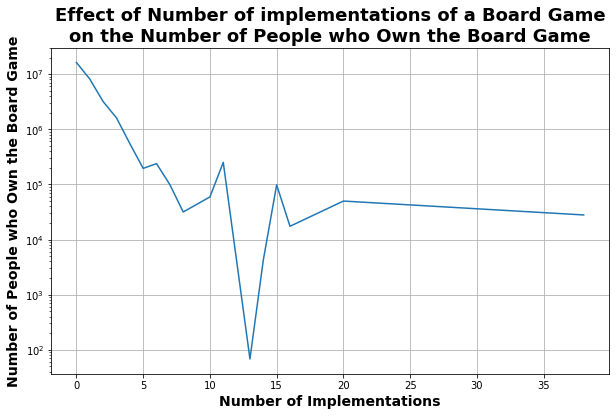

In [118]:
df1 = df.groupby('NumImplementations')['NumOwned'].sum()
ax = df1.plot()
ax.grid(True)
ax.set_yscale('log')
plt.title("Effect of Number of implementations of a Board Game\non the Number of People who Own the Board Game", fontsize=18, fontweight = 'bold')
ax.set_ylabel("Number of People who Own the Board Game", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Number of Implementations", fontsize = 14, fontweight = 'bold')

Text(0.5, 0, 'Number of Alternates versions')

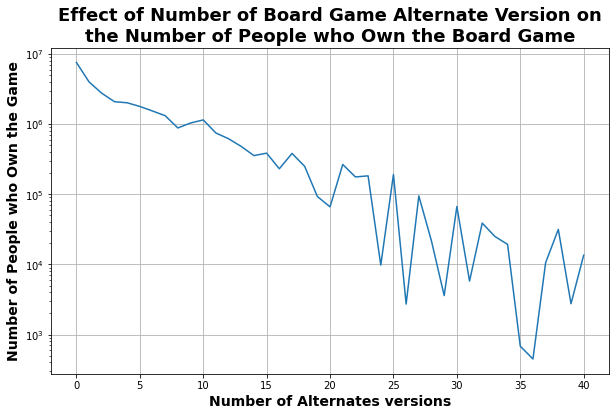

In [119]:
df3 = df.groupby('NumAlternates')['NumOwned'].sum()
ax = df3.plot()
ax.grid(True)
ax.set_yscale('log')
plt.title("Effect of Number of Board Game Alternate Version on\nthe Number of People who Own the Board Game", fontsize=18, fontweight = 'bold')
ax.set_ylabel("Number of People who Own the Game", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Number of Alternates Versions", fontsize = 14, fontweight = 'bold')

### Data Point 7: Play time
We are mainly interested in understanding the effect of play time of a game with its popularity. The column 'MfgPlaytime' show the play time as per the manufacturer recommendations. The columns 'ComMinPlaytime' and 'ComMaxPlaytime'show the minimum and maximun play time of the game as per the community

Text(0.5, 0, 'Manufacturer Recommend Play Time [minutes]')

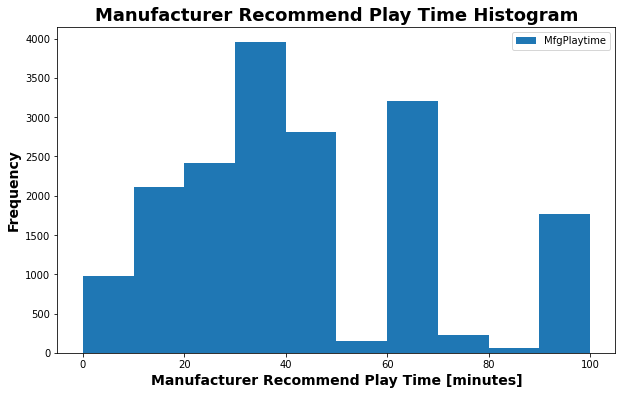

In [120]:
games_df['MfgPlaytime_log'] = np.log(games_df['MfgPlaytime'], where=games_df['MfgPlaytime'] > 0)
df = games_df[['MfgPlaytime']]
df = df.drop(df.index[df['MfgPlaytime'] >100])
fig = df.plot.hist()
plt.title('Manufacturer Recommend Play Time Histogram', fontsize=18, fontweight = 'bold')
plt.ylabel("Frequency", fontsize = 14, fontweight = 'bold')
plt.xlabel("Manufacturer Recommend Play Time [minutes]", fontsize = 14, fontweight = 'bold')

Text(0.5, 1.0, 'Relationship Between the Manufacturer Recommend Play Time\nand Popularity of The Board Game')

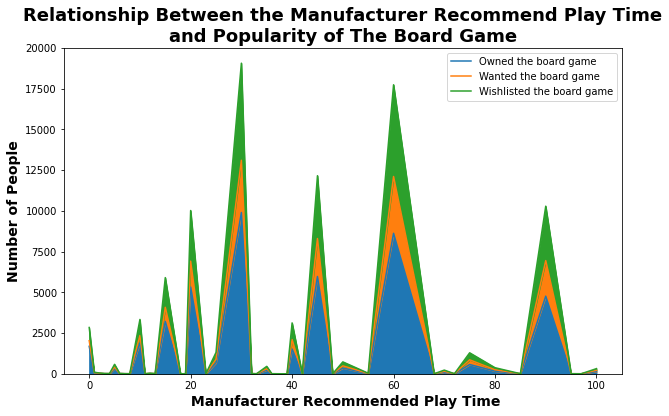

In [122]:
df = games_df[['MfgPlaytime','NumOwned_log','NumWant_log','NumWish_log']]
df = df.drop(df.index[df['MfgPlaytime'] >100])
df = df.groupby('MfgPlaytime')['NumOwned_log','NumWant_log','NumWish_log'].sum()
ax = df.plot.area()
ax.legend(['Owned the board game', 'Wanted the board game','Wishlisted the board game'])
ax.set_ylabel("Number of People", fontsize = 14, fontweight = 'bold')
ax.set_xlabel(" Manufacturer Recommended Play Time", fontsize = 14, fontweight = 'bold')
plt.title('Relationship Between the Manufacturer Recommend Play Time\nand Popularity of The Board Game', fontsize=18, fontweight = 'bold')

#### Difference in the Community Average play times and the manufacturer recomended play time
'MfgPlaytime' shows the play time as per the manufacturer recommendations. The columns 'ComMinPlaytime' and 'ComMaxPlaytime' present the minimum and maximun play time of the game as per the community

Text(0.5, 0, 'Number of Alternate Board Game Versions')

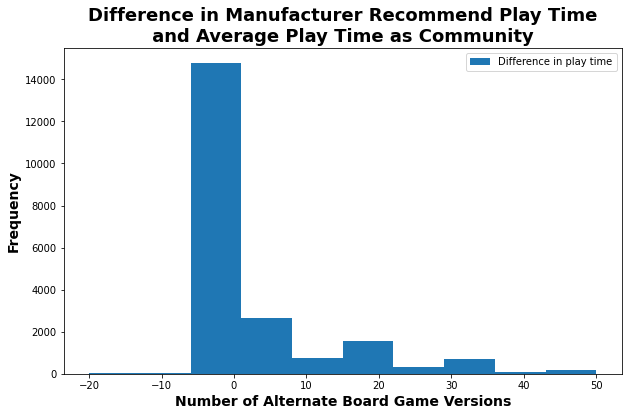

In [60]:
games_df['ComMfgChange'] = games_df['MfgPlaytime']- ((games_df['ComMinPlaytime'] + games_df['ComMaxPlaytime'])/2)
# games_df['ComMfgChange'] =  (k, where=k > 0)
df = games_df[['ComMfgChange']]
df = df.drop(df.index[df['ComMfgChange'] >50])
df = df.drop(df.index[df['ComMfgChange'] <-20])
ax = df.plot.hist()
ax.legend(['Difference in play time'])
plt.title('Difference in Manufacturer Recommend Play Time\n and Average Play Time as Community ', fontsize=18, fontweight = 'bold')
ax.set_ylabel("Frequency", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Number of Alternate Board Game Versions", fontsize = 14, fontweight = 'bold')

### Data Point 8: Effect of Kickstart
As a new manufacturer, it is also interesting to see what effect Kickstarter campaigns have had. For example, we presumed that,

Kickstarter programs generate a buzz even before the games has been developed at no expenses
Certain categories have a higher change of getting on Kickstarter than others
##### Category wise successful Kickstarted games

Text(0.5, 0, 'Board Game Categories')

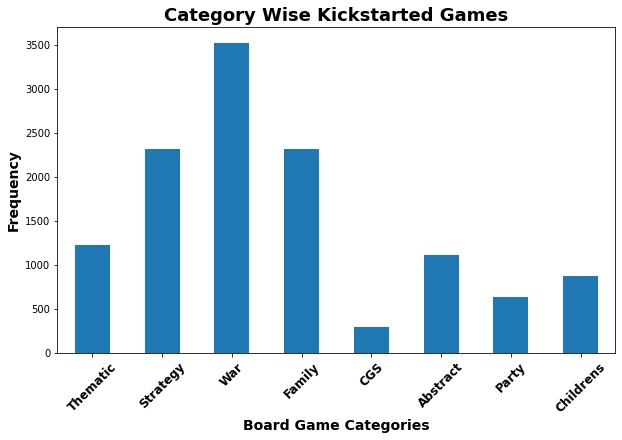

In [74]:
df = games_df.set_index(['Kickstarted'])[['Cat:Thematic', 'Cat:Strategy', 'Cat:War',
       'Cat:Family', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens']]
ax = df.sum().plot.bar(xlabel='Categories', ylabel='Counts', title='Category wise Kickstarted Games')
plt.title('Category Wise Kickstarted Games', fontsize=18, fontweight = 'bold')
ax.set_xticklabels(['Thematic', 'Strategy', 'War', 'Family', 'CGS', 'Abstract', 'Party', 'Childrens'], fontweight='bold', fontsize=12, rotation=45)
ax.set_ylabel("Frequency", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Board Game Categories", fontsize = 14, fontweight = 'bold')

In [75]:
df = df.groupby(df.index).sum().T

([<matplotlib.axis.XTick at 0x13e9f0670>,
 [Text(0, 0, 'Thematic'),
  Text(0, 0, 'Strategy'),
  Text(0, 0, 'War'),
  Text(0, 0, 'Family'),
  Text(0, 0, 'CGS'),
  Text(0, 0, 'Abstract'),
  Text(0, 0, 'Party'),
  Text(0, 0, 'Childrens')])

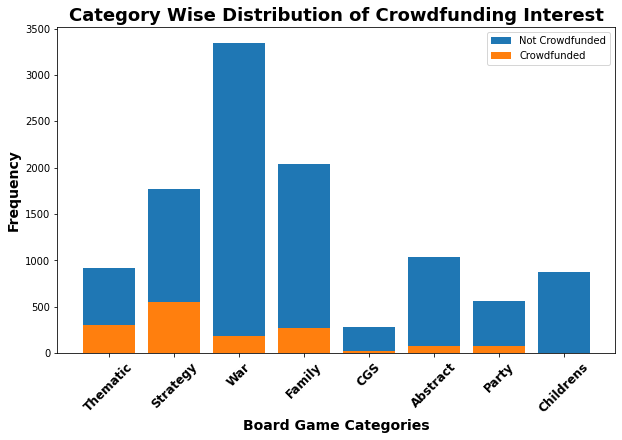

In [77]:
plt.bar(df.index.tolist(), df[0])
plt.bar(df.index.tolist(), df[1])
plt.legend(['Not Crowdfunded','Crowdfunded'])
plt.title('Category Wise Distribution of Crowdfunding Interest', fontsize=18, fontweight = 'bold')
plt.ylabel("Frequency", fontsize = 14, fontweight = 'bold')
plt.xlabel("Board Game Categories", fontsize = 14, fontweight = 'bold')
plt.xticks(df.index.tolist(), ['Thematic', 'Strategy', 'War', 'Family', 'CGS', 'Abstract', 'Party', 'Childrens'], fontweight='bold', fontsize=12, rotation=45)

#### Theme wise successful Kickstarted games
There are nearly 200+ themes and most of them barely have any crowdfunding. Thus we consider only the effect of those themes where the number of games crowdfunded is over 100

Text(0.5, 0, 'Board Game Themes')

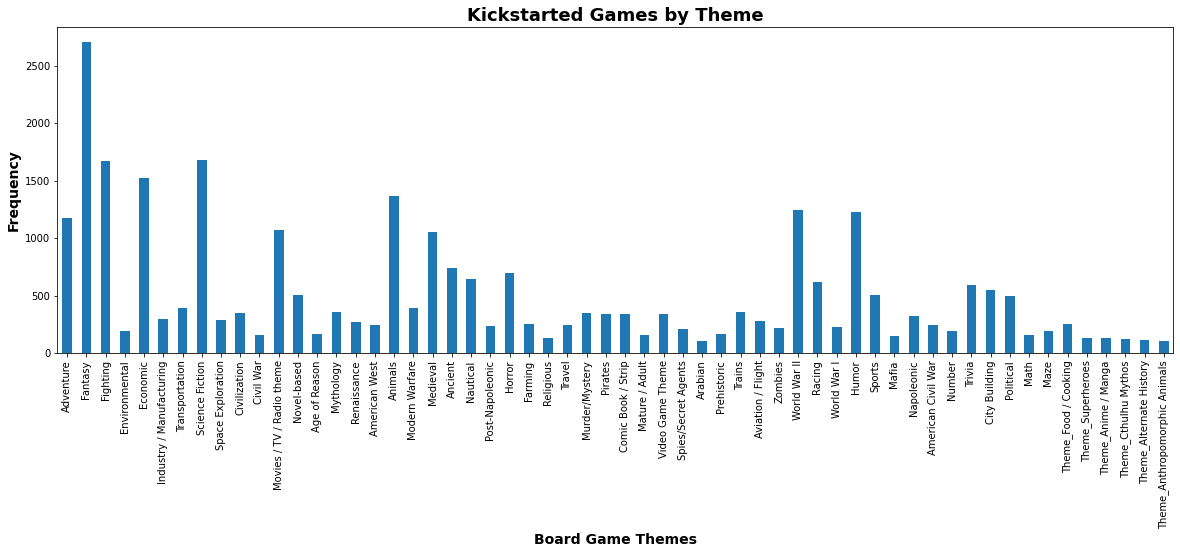

In [79]:
df = themes_df
df['Kickstarted'] = games_df['Kickstarted']
df2 = df.set_index(['Kickstarted']).sum()
ax = df2[df2>100].plot.bar(xlabel='Theme', ylabel='Counts',
            title='Kickstarted games by Theme',
            figsize=(20,6))
plt.title('Kickstarted Games by Theme', fontsize=18, fontweight = 'bold')
ax.set_ylabel("Frequency", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Board Game Themes", fontsize = 14, fontweight = 'bold')

### Data Point 9: Top 10 Board Game Themes for Different Board Game Categories
Visualizing top 10 board game themes for different board game categories for the game developers to understand which board game themes are the most common for different board game categories. With the user rating data and board game themes data, board game developers can determine which board games themes designs are considered a success and which are not. Including the right board game design themes are crucial to capture the interests of board game lovers and increase player engagement towards the board game.

In [80]:
# Get the original data
themes_df = backup_themes_df.copy()

# Get Board Game Themes list
board_game_themes = themes_df.columns.values.tolist()

# Initialize an array that stores counts of Row = Board Game Themes, Column = Board Game Categories
board_game_Theme_vs_Catg = np.zeros((len(themes_df.columns), len(board_game_categories)))

# Get the Themes counts based on board game category
board_game_Theme_vs_Catg = manipulate_Y_vs_X_data(games_df, board_game_Theme_vs_Catg, themes_df)

# Convert the board_game_Theme_vs_Catg array to dataframe
board_game_Theme_vs_Catg_df = pd.DataFrame(board_game_Theme_vs_Catg, index = board_game_themes, columns = board_game_categories)

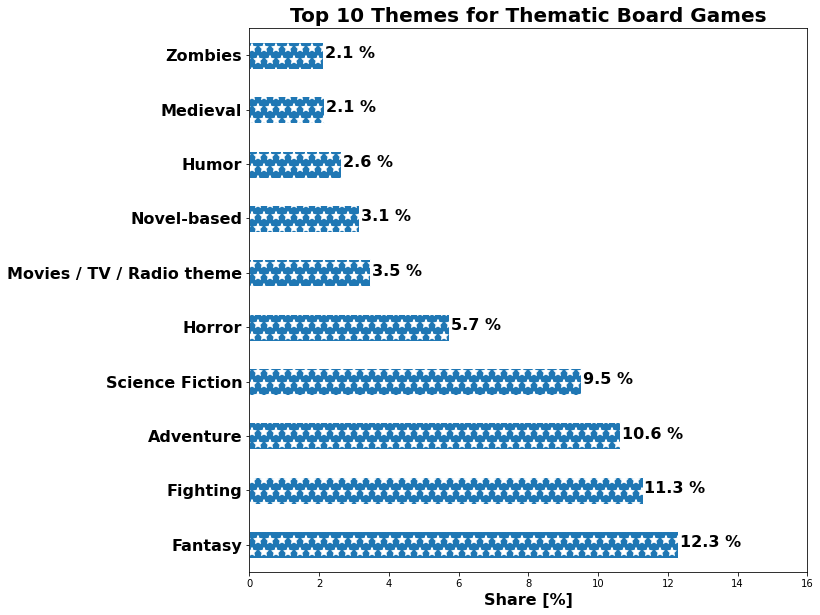

In [81]:
# Plot top 10 themes for thematic board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes' ,'Thematic')
sorted_thematic_df = board_game_Theme_vs_Catg_df.nlargest(10, 'Thematic')

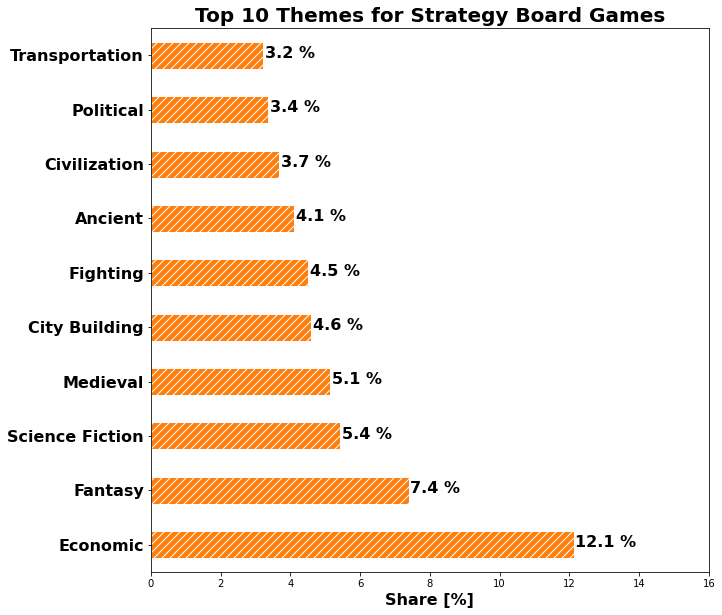

In [82]:
# Top 10 themes for strategy board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'Strategy', plt_hatch = "///", plt_color = '#ff7f0e')
sorted_strategy_df = board_game_Theme_vs_Catg_df.nlargest(10, 'Strategy')

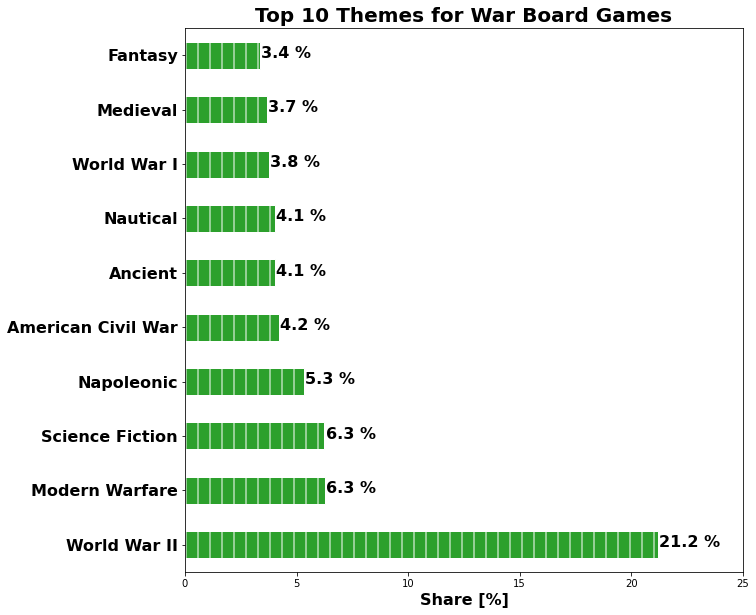

In [83]:
# Top 10 themes for war board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'War', plt_hatch = "|", plt_color = '#2ca02c')
sorted_war_df = board_game_Theme_vs_Catg_df.nlargest(10, 'War')

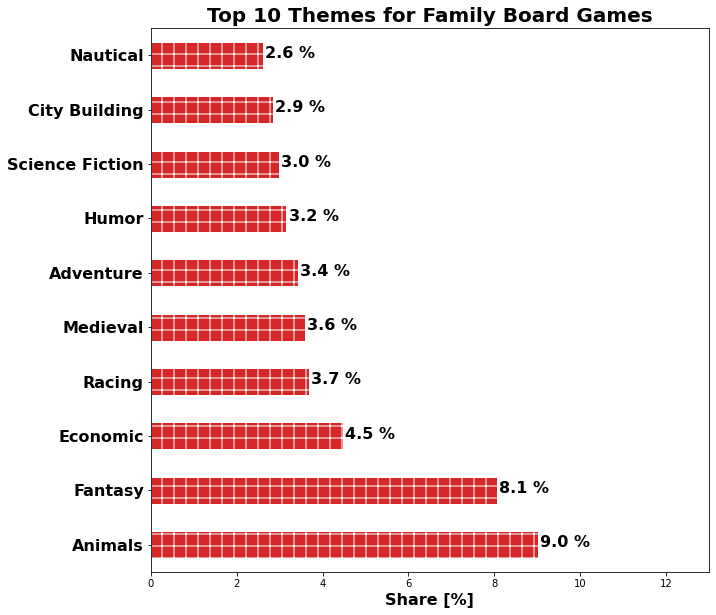

In [89]:
# Top 10 themes for family board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'Family', plt_hatch = "+", plt_color = '#d62728')
sorted_family_df = board_game_Theme_vs_Catg_df.nlargest(10, 'Family')

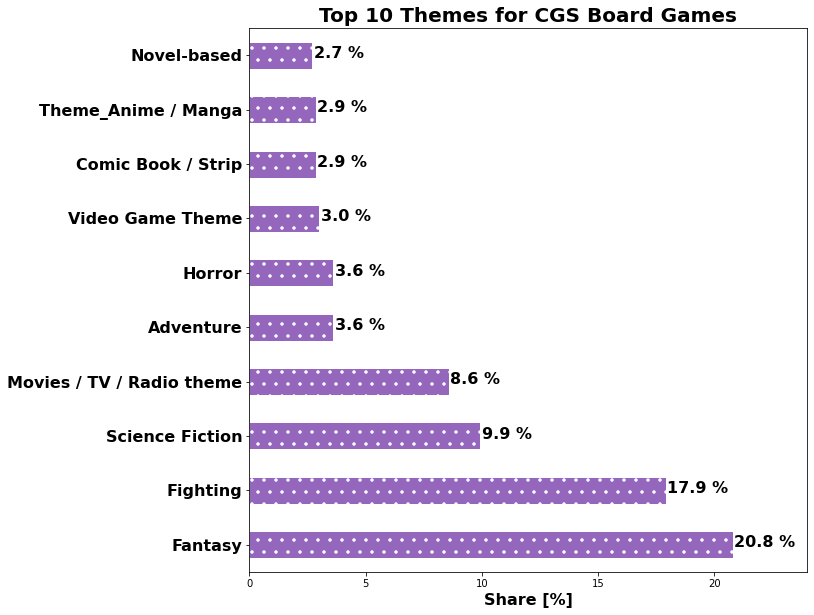

In [84]:
# Top 10 themes for CSG board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'CGS', plt_hatch = ".", plt_color = '#9467bd')
sorted_cgs_df = board_game_Theme_vs_Catg_df.nlargest(10, 'CGS')

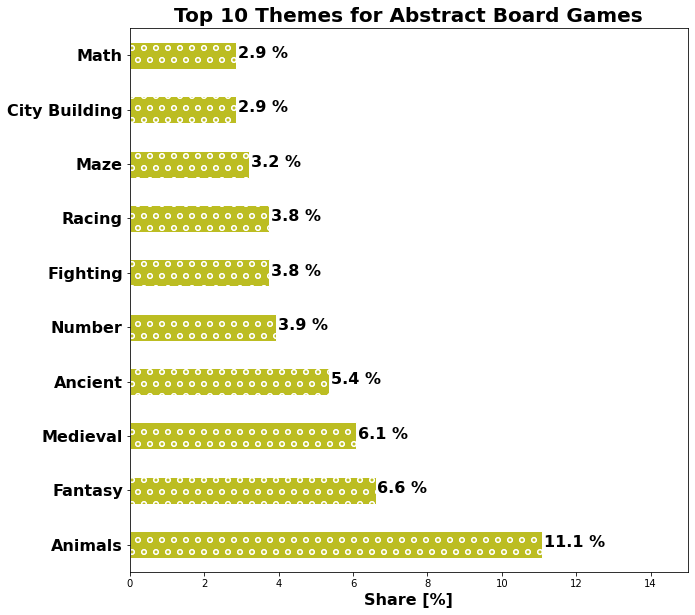

In [86]:
# Top 10 themes for Abstract board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'Abstract', plt_hatch = "o", plt_color = '#bcbd22')
sorted_abstract_df = board_game_Theme_vs_Catg_df.nlargest(10, 'Abstract')

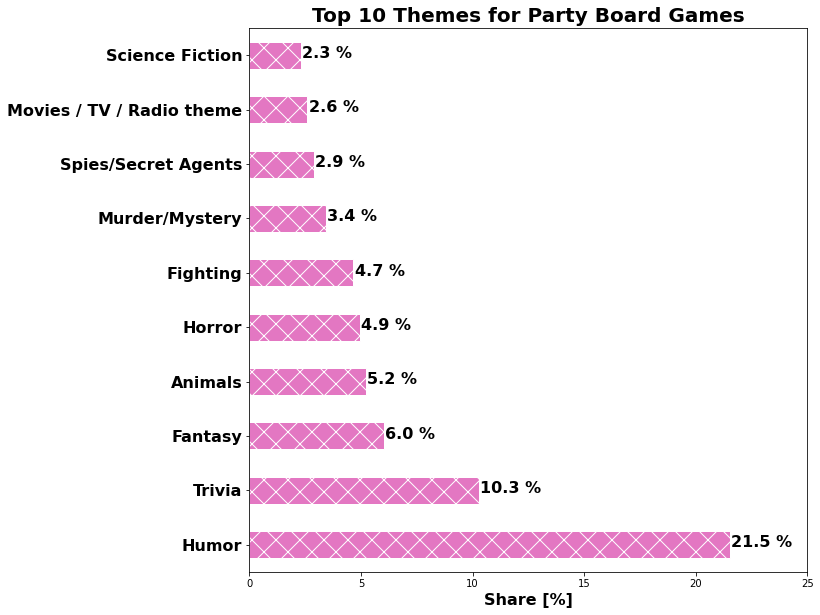

In [85]:
# Top 10 themes for Party board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'Party', plt_hatch = "x", plt_color = '#e377c2')
sorted_party_df = board_game_Theme_vs_Catg_df.nlargest(10, 'Party')

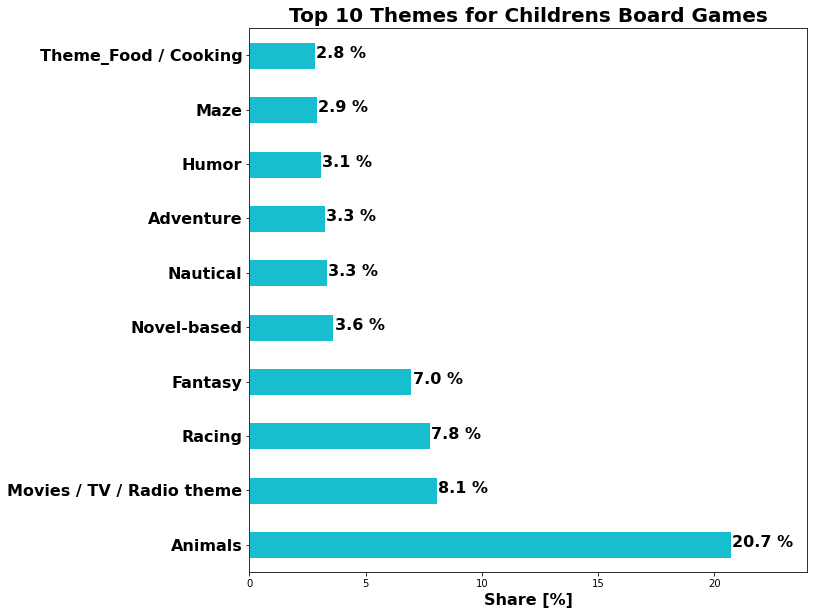

In [87]:
# Top 10 themes for Childrens board game category
plot_top_10_hbar(board_game_Theme_vs_Catg_df, 'Themes', 'Childrens', plt_hatch = "", plt_color = '#17becf')
sorted_childrens_df = board_game_Theme_vs_Catg_df.nlargest(10, 'Childrens')

In [90]:
# Get the top 10 list and convert to list for each board game category
sorted_thematic_list = sorted_thematic_df.index[:10].tolist()
sorted_strategy_list = sorted_strategy_df.index[:10].tolist()
sorted_war_list = sorted_war_df.index[:10].tolist()
sorted_family_list = sorted_family_df.index[:10].tolist()
sorted_cgs_list = sorted_cgs_df.index[:10].tolist()
sorted_abstract_list = sorted_abstract_df.index[:10].tolist()
sorted_party_list = sorted_party_df.index[:10].tolist()
sorted_childrens_list = sorted_childrens_df.index[:10].tolist()

# Append to the theme list
theme_list = []
theme_list.extend(sorted_thematic_list)
theme_list.extend(sorted_strategy_list)
theme_list.extend(sorted_war_list)
theme_list.extend(sorted_family_list)
theme_list.extend(sorted_cgs_list)
theme_list.extend(sorted_abstract_list)
theme_list.extend(sorted_party_list)
theme_list.extend(sorted_childrens_list)

# Display which themes appear the most
print(Counter(theme_list))

Counter({'Fantasy': 8, 'Science Fiction': 6, 'Fighting': 5, 'Medieval': 5, 'Adventure': 4, 'Movies / TV / Radio theme': 4, 'Humor': 4, 'Animals': 4, 'Horror': 3, 'Novel-based': 3, 'City Building': 3, 'Ancient': 3, 'Nautical': 3, 'Racing': 3, 'Economic': 2, 'Maze': 2, 'Zombies': 1, 'Civilization': 1, 'Political': 1, 'Transportation': 1, 'World War II': 1, 'Modern Warfare': 1, 'Napoleonic': 1, 'American Civil War': 1, 'World War I': 1, 'Video Game Theme': 1, 'Comic Book / Strip': 1, 'Theme_Anime / Manga': 1, 'Number': 1, 'Math': 1, 'Trivia': 1, 'Murder/Mystery': 1, 'Spies/Secret Agents': 1, 'Theme_Food / Cooking': 1})


### Data Point 10: Top 10 Board Game Mechanics for Different Board Game Categories
Visualizing the top 10 board game mechanics for different board game categories data is important for the game developers to understand which board game mechanics are the most common for different board game categories. With the user rating data and board game mechanics data, board game developers can determine which board games mechanics designs are considered a success and which are not. Including the right board game design, mechanics are crucial to capture the interests of board game lovers and increase player engagement towards the board game.

In [91]:
# Get the original data
mechanics_df = backup_mechanics_df.copy()

# Get Board Game Mechanics list
board_game_mechanics = mechanics_df.columns.values.tolist()
    
# Initialize an array that stores counts of Row = Board Game Mechanics, Column = Board Game Categories
board_game_Mech_vs_Catg = np.zeros((len(mechanics_df.columns), len(board_game_categories)))

# Get the Themes counts based on board game category
board_game_Mech_vs_Catg = manipulate_Y_vs_X_data(games_df, board_game_Mech_vs_Catg, mechanics_df)

# Convert the board_game_Mech_vs_Catg array to dataframe
board_game_Mech_vs_Catg_df = pd.DataFrame(board_game_Mech_vs_Catg, index = board_game_mechanics, columns = board_game_categories)

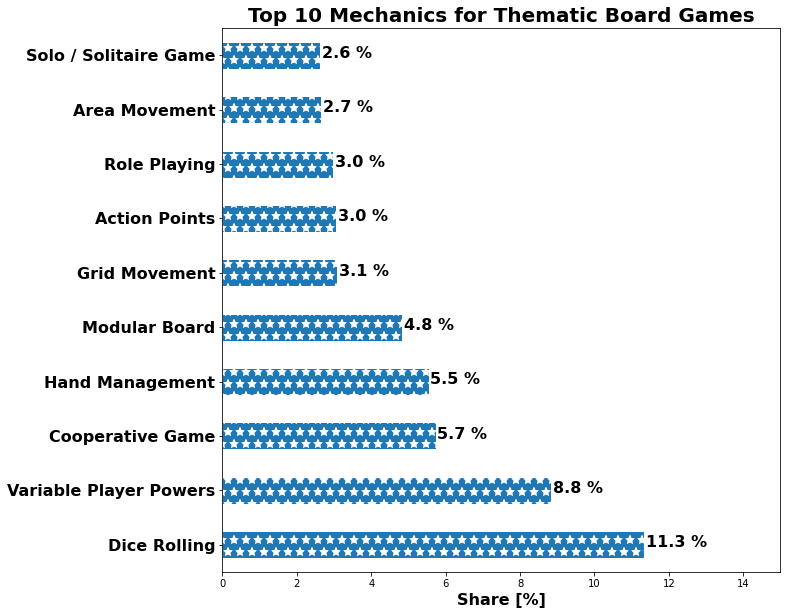

In [92]:
# Top 10 mechanics for thematic board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'Thematic')
sorted_thematic_df = board_game_Mech_vs_Catg_df.nlargest(10, 'Thematic')

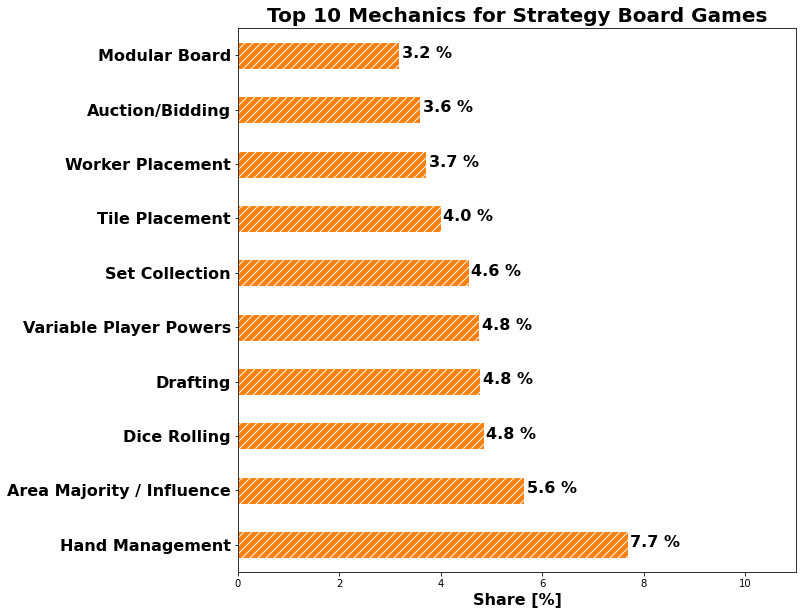

In [94]:
# Top 10 mechanics for strategy board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'Strategy', plt_hatch = "///", plt_color = '#ff7f0e')
sorted_strategy_df = board_game_Mech_vs_Catg_df.nlargest(10, 'Strategy')

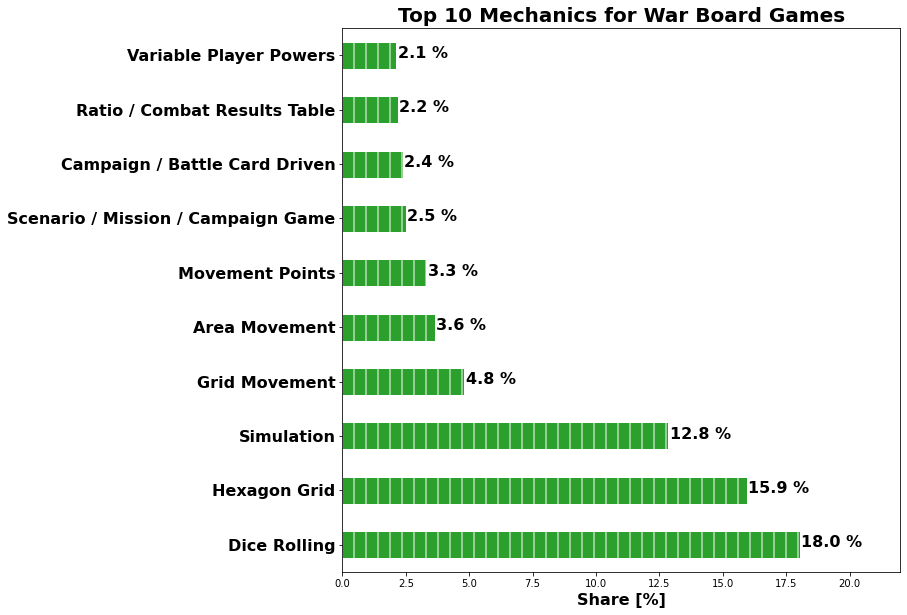

In [95]:
# Top 10 mechanics for war board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'War', plt_hatch = "|", plt_color = '#2ca02c')
sorted_war_df = board_game_Mech_vs_Catg_df.nlargest(10, 'War')

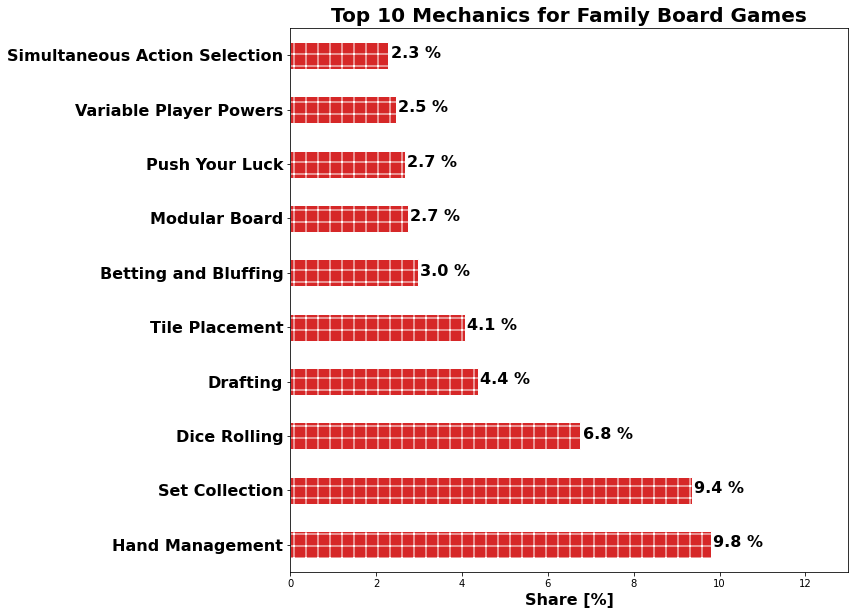

In [96]:
# Top 10 mechanics for family board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'Family', plt_hatch = "+", plt_color = '#d62728')
sorted_family_df = board_game_Mech_vs_Catg_df.nlargest(10, 'Family')

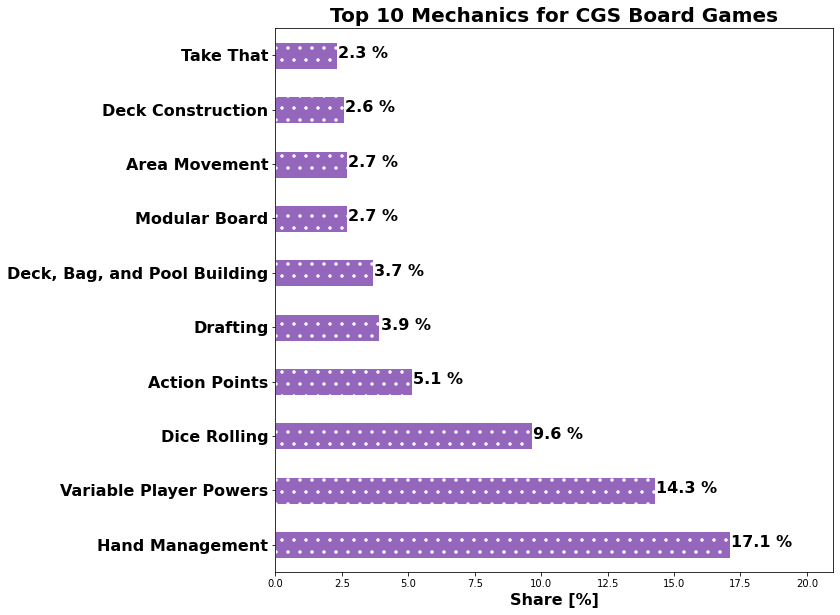

In [97]:
# Top 10 mechanics for CSG board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'CGS', plt_hatch = ".", plt_color = '#9467bd')
sorted_cgs_df = board_game_Mech_vs_Catg_df.nlargest(10, 'CGS')

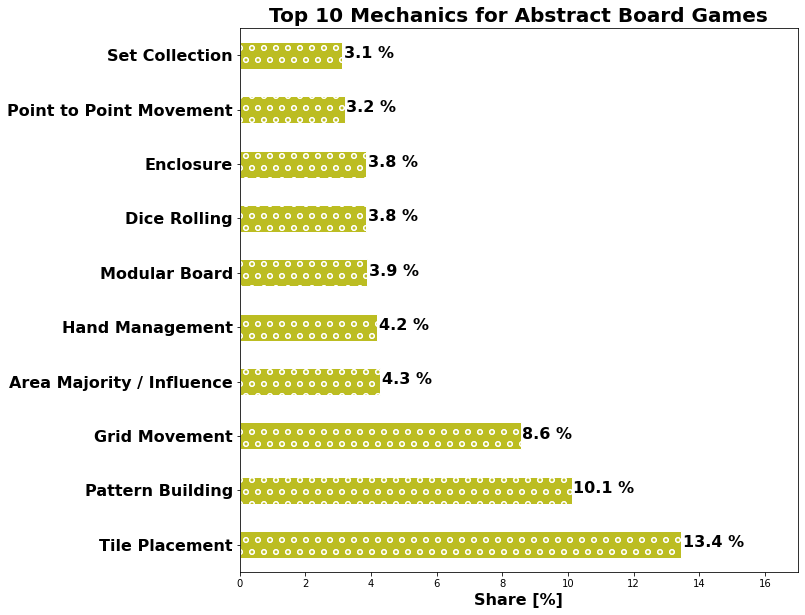

In [98]:
# Top 10 mechanics for Abstract board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'Abstract', plt_hatch = "o", plt_color = '#bcbd22')
sorted_abstract_df = board_game_Mech_vs_Catg_df.nlargest(10, 'Abstract')

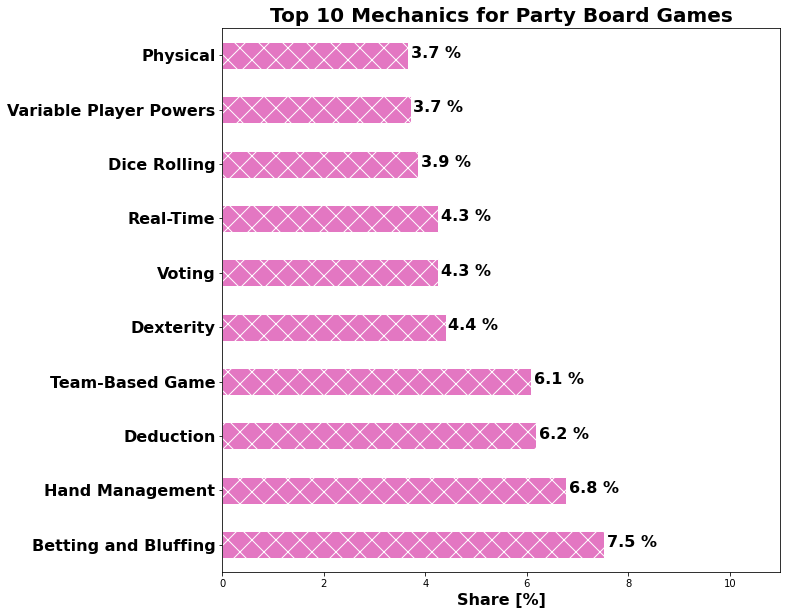

In [99]:
# Top 10 mechanics for Party board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'Party', plt_hatch = "x", plt_color = '#e377c2')
sorted_party_df = board_game_Mech_vs_Catg_df.nlargest(10, 'Party')

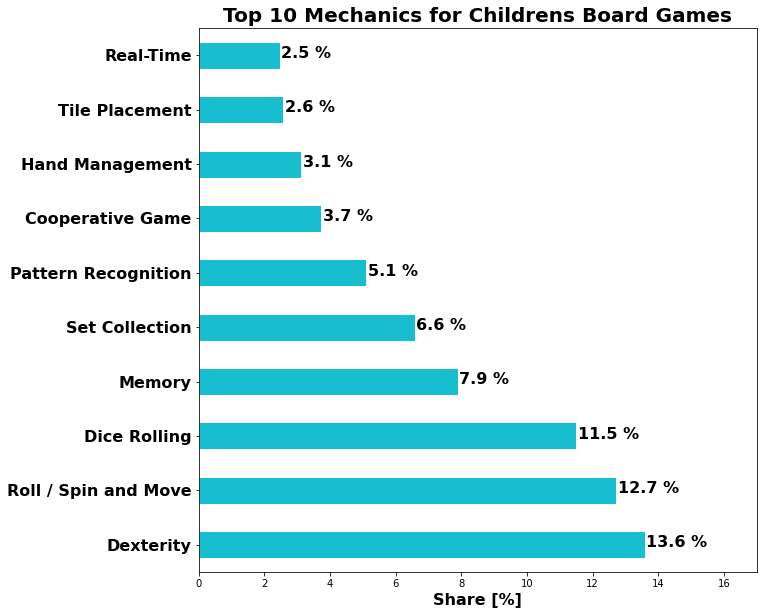

In [100]:
# Top 10 mechanics for Childrens board game category
plot_top_10_hbar(board_game_Mech_vs_Catg_df, 'Mechanics', 'Childrens', plt_hatch = "", plt_color = '#17becf')
sorted_childrens_df = board_game_Mech_vs_Catg_df.nlargest(10, 'Childrens')

In [101]:
# Get the top 10 list and convert to list for each board game category
sorted_thematic_list = sorted_thematic_df.index[:10].tolist()
sorted_strategy_list = sorted_strategy_df.index[:10].tolist()
sorted_war_list = sorted_war_df.index[:10].tolist()
sorted_family_list = sorted_family_df.index[:10].tolist()
sorted_cgs_list = sorted_cgs_df.index[:10].tolist()
sorted_abstract_list = sorted_abstract_df.index[:10].tolist()
sorted_party_list = sorted_party_df.index[:10].tolist()
sorted_childrens_list = sorted_childrens_df.index[:10].tolist()

# Append to the mechanic list
mechanic_list = []
mechanic_list.extend(sorted_thematic_list)
mechanic_list.extend(sorted_strategy_list)
mechanic_list.extend(sorted_war_list)
mechanic_list.extend(sorted_family_list)
mechanic_list.extend(sorted_cgs_list)
mechanic_list.extend(sorted_abstract_list)
mechanic_list.extend(sorted_party_list)
mechanic_list.extend(sorted_childrens_list)

# Display which mechanics appear the most
print(Counter(mechanic_list))

Counter({'Dice Rolling': 8, 'Hand Management': 7, 'Variable Player Powers': 6, 'Modular Board': 5, 'Set Collection': 4, 'Tile Placement': 4, 'Grid Movement': 3, 'Area Movement': 3, 'Drafting': 3, 'Cooperative Game': 2, 'Action Points': 2, 'Area Majority / Influence': 2, 'Betting and Bluffing': 2, 'Dexterity': 2, 'Real-Time': 2, 'Role Playing': 1, 'Solo / Solitaire Game': 1, 'Worker Placement': 1, 'Auction/Bidding': 1, 'Hexagon Grid': 1, 'Simulation': 1, 'Movement Points': 1, 'Scenario / Mission / Campaign Game': 1, 'Campaign / Battle Card Driven': 1, 'Ratio / Combat Results Table': 1, 'Push Your Luck': 1, 'Simultaneous Action Selection': 1, 'Deck, Bag, and Pool Building': 1, 'Deck Construction': 1, 'Take That': 1, 'Pattern Building': 1, 'Enclosure': 1, 'Point to Point Movement': 1, 'Deduction': 1, 'Team-Based Game': 1, 'Voting': 1, 'Physical': 1, 'Roll / Spin and Move': 1, 'Memory': 1, 'Pattern Recognition': 1})


### Data Point 11: Board Game Subcategories
The pie chart presents which are the most popular board game subcategories.

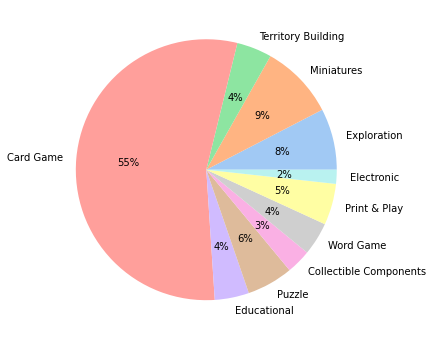

In [102]:
# subcategories
summed = subcategories_df.sum(axis = 0, skipna = True)  # sum all the categories
summed = summed.drop(labels = ["BGGId"])  # drop the bgg id sum
summeddf = pd.DataFrame(summed, columns=["Count"])  # convert to dataframe


data = summeddf["Count"].tolist()  # extract list of data(count of each category)
label= summeddf.index.tolist()  # extract list of category

colors = sns.color_palette('pastel')[0:len(label)]
plt.pie(data, labels = label, colors = colors, autopct='%.0f%%')
plt.show()

The pie chart presents which are the most popular board game categories.

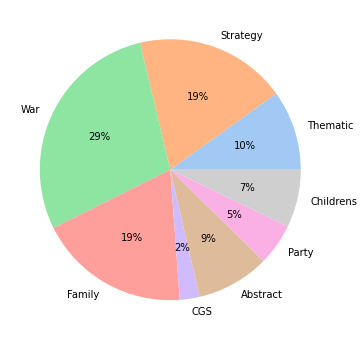

In [104]:
# categories
dfcat = games_df[["Cat:Thematic","Cat:Strategy","Cat:War","Cat:Family","Cat:CGS","Cat:Abstract","Cat:Party","Cat:Childrens"]]
summed = dfcat.sum(axis = 0, skipna = True)  # sum all the categories
summeddf = pd.DataFrame(summed, columns=["Count"])  # convert to dataframe

data = summeddf["Count"].tolist()  # extract list of data(count of each category)
label= summeddf.index.tolist()  # extract list of category

colors = sns.color_palette('pastel')[0:len(label)]
plt.pie(data, labels = ['Thematic', 'Strategy', 'War', 'Family', 'CGS', 'Abstract', 'Party', 'Childrens'], colors = colors, autopct='%.0f%%')
plt.show()

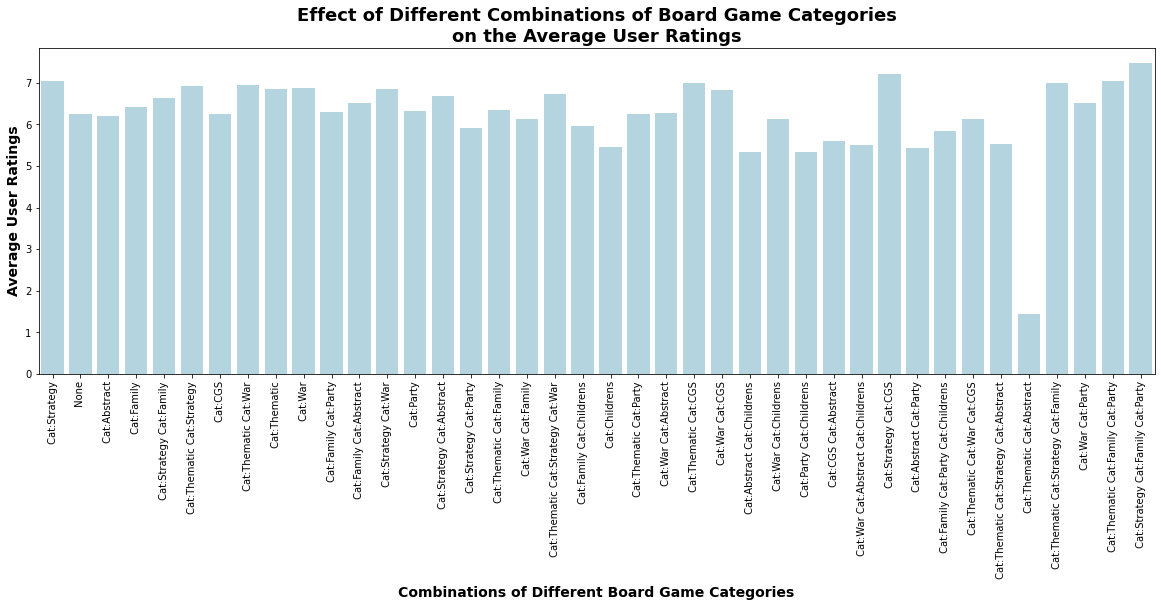

In [110]:
# mean of average rating across different categories
games_df["tags"] = ''

list = ["Cat:Thematic","Cat:Strategy","Cat:War","Cat:Family","Cat:CGS","Cat:Abstract","Cat:Party","Cat:Childrens"]
for col_name in list:
    games_df.loc[games_df[col_name] == 1, 'tags'] = games_df['tags'] + ' ' + col_name  # get a column with the categories

list2 = games_df['tags'].tolist()
for i in range(0,len(list2)):
    if list2[i] == '':
        list2[i] = ' None'  # for all the none types give a name none

games_df['tags'] = list2    
    
dfnew = games_df[["AvgRating","tags"]]
dfnew.groupby('tags').mean()  # get the mean of the average ratings of games of each category

plt.figure(figsize=(20,6))
fig = sns.barplot(x="tags",y="AvgRating",data=dfnew, color="lightblue",ci=None)
plt.title('Effect of Different Combinations of Board Game Categories\non the Average User Ratings', fontsize=18, fontweight = 'bold')
plt.ylabel("Average User Ratings", fontsize = 14, fontweight = 'bold')
plt.xlabel("Combinations of Different Board Game Categories", fontsize = 14, fontweight = 'bold')
plt.xticks(rotation=90)
plt.show()

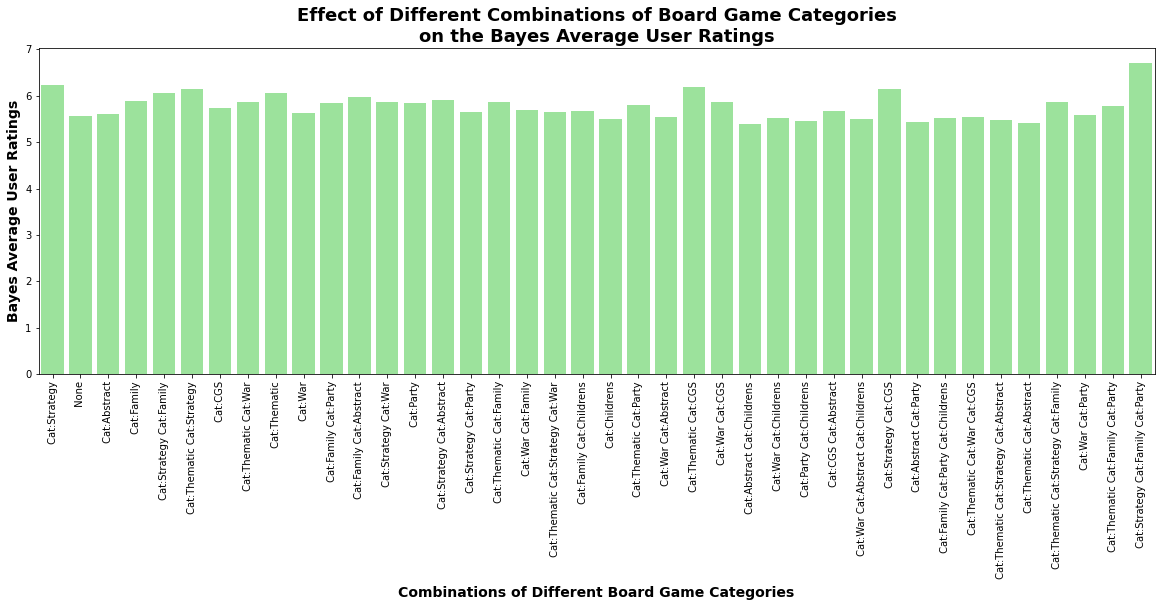

In [111]:
# mean of bayes rating across different categories
games_df["tags"] = ''

list = ["Cat:Thematic","Cat:Strategy","Cat:War","Cat:Family","Cat:CGS","Cat:Abstract","Cat:Party","Cat:Childrens"]
for col_name in list:
    games_df.loc[games_df[col_name] == 1, 'tags'] = games_df['tags'] + ' ' + col_name  # get a column with the categories

list2 = games_df['tags'].tolist()
for i in range(0,len(list2)):
    if list2[i] == '':
        list2[i] = ' None'  # for all the none types give a name none

games_df['tags'] = list2    
    
dfnew = games_df[["BayesAvgRating","tags"]]
dfnew.groupby('tags').mean()  # get the mean of the average ratings of games of each category


plt.figure(figsize=(20,6))
fig = sns.barplot(x="tags",y="BayesAvgRating",data=dfnew, color="lightgreen",ci=None)
plt.title('Effect of Different Combinations of Board Game Categories\non the Bayes Average User Ratings', fontsize=18, fontweight = 'bold')
plt.ylabel("Bayes Average User Ratings", fontsize = 14, fontweight = 'bold')
plt.xlabel("Combinations of Different Board Game Categories", fontsize = 14, fontweight = 'bold')
plt.xticks(rotation=90)
plt.show()

### Data Point 11: Publisher
To be able to sales as many copies of games we must find a will publisher with a track record of publishing games similar games.

In [112]:
#join tables
combined_df = games_df.join(publisher_df.set_index('BGGId'))

In [113]:
#filter game by ranking
filter_rating =  combined_df['AvgRating'] > 7
filter_games_rating = combined_df[filter_rating]

In [114]:
#filter game by ranking
filter_rating_weight = filter_games_rating['GameWeight'] > 2
filter_games_rating_weight = filter_games_rating[filter_rating_weight]

In [115]:
# Sum the count of games published by each publisher
sum_publish = pd.DataFrame(filter_games_rating_weight.loc[:, "Moskito Spiele" :"Hidden Industries GmbH"].sum(axis=0))
sum_publish.columns=["Count"]
sum_publish = sum_publish.sort_values(by=['Count']) # sort by year

In [116]:
# Bar graph of top ten publisher high weight games
fig = px.bar(sum_publish['Count'].nlargest(10),
             labels={
                     "value": "Number of Published Games",
                     "index": "Publisher",
                 },title="Desired Publishers")

fig.show()